In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np
import scipy

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.vis import plot, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav

from mhsflex.field2d import check_fluxbalance, alpha_HS04
import mhsflex.fluxbalance
from mhsflex.metrics import pearson_corr_coeff_issi_2

rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

c2 = (0.420, 0.502, 1.000)
c3 = "black"
c4 = (1.000, 0.224, 0.376)
c5 = (0.784, 0.231, 0.576)
c7 = (0.992, 0.251, 0.733)
c8 = (0.867, 0.871, 0.184)
c9 = (0.949, 0.922, 0.678)
c10 = (0.984, 0.455, 0.231)
c11 = (0.765, 0.835, 0.922)
c12 = (0.965, 0.694, 0.486)
c13 = (0.992, 0.584, 0.820)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "/Users/lilli/Desktop/mflex/data/RMHD_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:18:26 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 10 records of which:
 - 6 are of type VARIABLE
 - 1 are of type TIMESTAMP
 - 1 are of type NOTICE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - b2dx [<class 'numpy.ndarray'>]
 - b2dy [<class 'numpy.ndarray'>]
 - b2dz [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


In [4]:
data_bz = data["b2dz"]
data_bx = data["b2dx"]
data_by = data["b2dy"]

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 64.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 192.0 * 10**-3
pixelsize_y_Mm = 192.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 41.6

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

deltaz = z0 / 10

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

xmax_Mm, ymax_Mm, zmax_Mm 98.304 49.152 41.6
nresol_x, nresol_y, nresol_z 512 256 650
pixelsize_x 0.192
pixelsize_y 0.192
pixelsize_z 0.064


In [5]:
folder = "/Users/lilli/Desktop/Thesis/ISSI_RMHD"

In [6]:
x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    pixelsize_x_Mm,
    pixelsize_y_Mm,
    pixelsize_z_Mm,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

x_grid, y_grid = np.meshgrid(data2d.x, data2d.y)

In [7]:
data3d = mhsflex.fluxbalance.Field3dData.load(folder + "/field")
# data3dLFF = mhsflex.fluxbalance.Field3dData.load(folder + "/fieldLFF")

In [8]:
path3dref = "/Users/lilli/Desktop/mflex/data/RMHD_3D_data.sav"
data3dref = scipy.io.readsav(path3dref, python_dict=True, verbose=True)

print(data3dref["info_unit"])
print(data3dref["info_pixel"])
print(data3dref["info_array"])

bx_ref = data3dref["b3dx"]
by_ref = data3dref["b3dy"]
bz_ref = data3dref["b3dz"]

pres_3d = data3dref["p3d"]  # * 10**-1
den_3d = data3dref["d3d"]  # * 10**3

--------------------------------------------------
Date: Tue Sep  6 15:19:40 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 8 are of type VARIABLE
 - 1 are of type TIMESTAMP
 - 1 are of type NOTICE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------
b'b3d, d3d, p3d: magnetic vector (Gauss), plasma density (g/cm^3), plasma pressure (dyn/cm^2)'
b'Pixel spacing: 192km*192km*64km'
b'Array example: d3d(nx,ny,nz)'


In [9]:
bx_rec = data3d.field[:, :, :, 1]
by_rec = data3d.field[:, :, :, 0]
bz_rec = data3d.field[:, :, :, 2]
print(bx_rec.shape)
print(by_rec.shape)
print(bz_rec.shape)

issi_bx = np.zeros_like(bx_rec)
issi_by = np.zeros_like(by_rec)
issi_bz = np.zeros_like(bz_rec)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = bx_ref[k, i, j]
            issi_by[i, j, k] = by_ref[k, i, j]
            issi_bz[i, j, k] = bz_ref[k, i, j]

B_ref = np.zeros((nresol_y, nresol_x, nresol_z, 3))

B_ref[:, :, :, 0] = issi_by[:, :, :]
B_ref[:, :, :, 1] = issi_bx[:, :, :]
B_ref[:, :, :, 2] = issi_bz[:, :, :]

(256, 512, 650)
(256, 512, 650)
(256, 512, 650)


In [15]:
T_PHOTOSPHERE = 6000.0  # Photospheric temperature
T_CORONA = 2.0 * 10.0**6  # Coronal temperature

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)
RHO0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)

P0 = T_PHOTOSPHERE * KB * RHO0 / MBAR  # plasma pressure in kg/(s^2 m)
MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

L = 10**6  # Lengthscale Mm
T0 = 10000.0
H = KB * T0 / (MBAR * G_SOLAR) / L
B0 = (
    data2d.bz.max()
)  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
PB0 = (B0 * 10**-4) ** 2 / (2 * MU0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
BETA0 = P0 / PB0  # Plasma Beta, ration plasma to magnetic pressure

temps = np.array((6000.0, 5500.0, 10000.0, 500000.0, 1000000.0, 1500000.0))  # Kelvin
heights = np.array((0.0, 0.5, 2.0, 2.2, 5.0, 100.0))

from mhsflex.fluxbalance import (
    bpressure_linear,
    bdensity_linear,
    btemp_linear,
    fpressure_linear,
    fdensity_linear,
)



In [11]:
temp = pres_3d[0, :, :] * 10**-2 /(den_3d[0, :, :] * 10**6) * MBAR / KB

In [12]:
temp.max()

10125.23853551151

In [13]:
backtemp = btemp_linear(data3d, heights, temps)
backpres = bpressure_linear(data3d, heights, temps)
backden = bdensity_linear(data3d, heights, temps)

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7309/3939284493.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


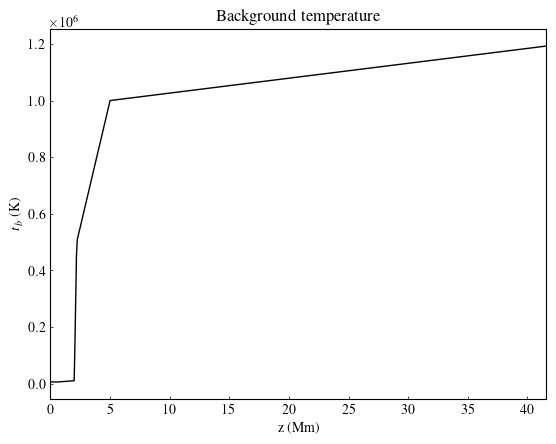

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7309/3939284493.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)
/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7309/3939284493.py:29: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 41.6])


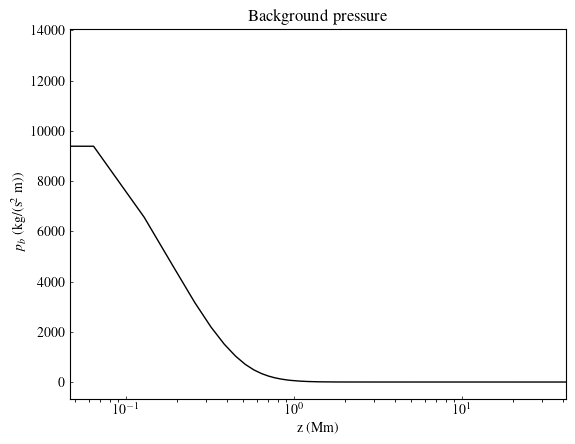

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7309/3939284493.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)
/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7309/3939284493.py:52: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 41.6])


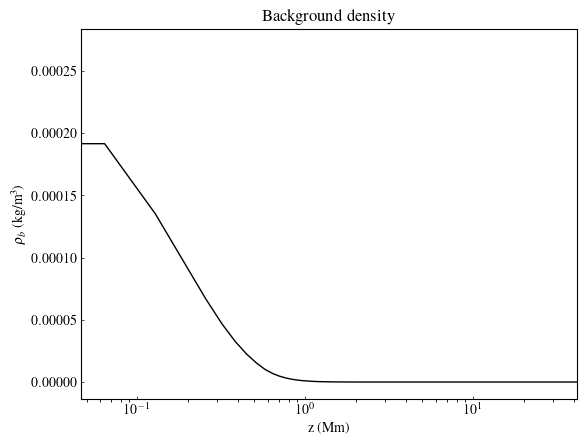

In [14]:
plt.plot(
    z_arr,
    backtemp,
    linewidth=1.0,
    color=c3,
)
# plt.ylabel(r"kg/($\textrm{s}^2$ m)")
plt.ylabel(r"$t_b$ (K)")
plt.xlabel("z (Mm)")
# plt.xscale("log")
plt.xlim([0, 41.6])
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plt.title(r"Background temperature")
plotname = folder + "/btemp.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    z_arr,
    BETA0 / 2.0 * backpres * (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=1.0,
    color=c3,
)
plt.ylabel(r"$p_b$ (kg/($\textrm{s}^2$ m))")
plt.xlabel("z (Mm)")
plt.legend(frameon=False)
plt.xscale("log")
plt.xlim([0, 41.6])
plt.tick_params(direction="in", length=2, width=0.5)
plt.title(r"Background pressure")
plotname = folder + "/bpres.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    z_arr,
    BETA0
    / (2.0 * H)
    * T0
    / T_PHOTOSPHERE
    * backden
    * (B0 * 10**-4) ** 2.0
    / (MU0 * G_SOLAR * L),
    linewidth=1.0,
    color=c3,
)
plt.ylabel(r"$\rho_b$ (kg/$\textrm{m}^3$)")
plt.xlabel("z (Mm)")
plt.legend(frameon=False)
plt.xscale("log")
plt.xlim([0, 41.6])
plt.tick_params(direction="in", length=2, width=0.5)
plt.title(r"Background density")
plotname = folder + "/bden.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [16]:
fpres = fpressure_linear(data3d, heights, temps)
fden = fdensity_linear(data3d, heights, temps)

fpresISSI = np.zeros_like(fpres)
fdenISSI = np.zeros_like(fden)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            fpresISSI[i, j, k] = pres_3d[k, i, j]
            fdenISSI[i, j, k] = den_3d[k, i, j]

In [17]:
magpres = np.zeros_like(fpres)
magpresISSI = np.zeros_like(fpres)

for iy in range(0, nresol_y):
    for ix in range(0, nresol_x):
        for iz in range(0, nresol_z):

            magpres[iy, ix, iz] = (
                (
                    data3d.field[iy, ix, iz, 0] ** 2
                    + data3d.field[iy, ix, iz, 1] ** 2
                    + data3d.field[iy, ix, iz, 2] ** 2
                )
                * (10**-4) ** 2
                / (2 * MU0)
            )

            magpresISSI[iy, ix, iz] = (
                (
                    B_ref[iy, ix, iz, 0] ** 2
                    + B_ref[iy, ix, iz, 1] ** 2
                    + B_ref[iy, ix, iz, 2] ** 2
                )
                * (10**-4) ** 2
                / (2 * MU0)
            )

In [18]:
plasmabeta = fpres / magpres
plasmabetaISSI = fpresISSI * 10**-2 / magpresISSI

In [19]:
magpresmean = np.zeros_like(z_arr)
magpresISSImean = np.zeros_like(z_arr)
plasmabetamean = np.zeros_like(z_arr)
plasmabetaISSImean = np.zeros_like(z_arr)

fpresmean = np.zeros_like(z_arr)
fpresISSImean = np.zeros_like(z_arr)

fdenmean = np.zeros_like(z_arr)
fdenISSImean = np.zeros_like(z_arr)


magpresmax = np.zeros_like(z_arr)
magpresISSImax = np.zeros_like(z_arr)

plasmabetamax = np.zeros_like(z_arr)
plasmabetaISSImax = np.zeros_like(z_arr)

fpresISSImax = np.zeros_like(z_arr)
fpresmax = np.zeros_like(z_arr)

fdenISSImax = np.zeros_like(z_arr)
fdenmax = np.zeros_like(z_arr)

magpresmin = np.zeros_like(z_arr)
magpresISSImin = np.zeros_like(z_arr)

plasmabetamin = np.zeros_like(z_arr)
plasmabetaISSImin = np.zeros_like(z_arr)

fpresISSImin = np.zeros_like(z_arr)
fpresmin = np.zeros_like(z_arr)

fdenISSImin = np.zeros_like(z_arr)
fdenmin = np.zeros_like(z_arr)

for iz in range(nresol_z):
    magpresmean[iz] = magpres[:, :, iz].mean()
    magpresISSImean[iz] = magpresISSI[:, :, iz].mean()

    plasmabetamean[iz] = plasmabeta[:, :, iz].mean()
    plasmabetaISSImean[iz] = plasmabetaISSI[:, :, iz].mean()

    fpresISSImean[iz] = fpresISSI[:, :, iz].mean()
    fpresmean[iz] = fpres[:, :, iz].mean()

    fdenISSImean[iz] = fdenISSI[:, :, iz].mean()
    fdenmean[iz] = fden[:, :, iz].mean()

    magpresmax[iz] = magpres[:, :, iz].max()
    magpresISSImax[iz] = magpresISSI[:, :, iz].max()

    plasmabetamax[iz] = plasmabeta[:, :, iz].max()
    plasmabetaISSImax[iz] = plasmabetaISSI[:, :, iz].max()

    fpresISSImax[iz] = fpresISSI[:, :, iz].max()
    fpresmax[iz] = fpres[:, :, iz].max()

    fdenISSImax[iz] = fdenISSI[:, :, iz].max()
    fdenmax[iz] = fden[:, :, iz].max()

    magpresmin[iz] = magpres[:, :, iz].min()
    magpresISSImin[iz] = magpresISSI[:, :, iz].min()

    plasmabetamin[iz] = plasmabeta[:, :, iz].min()
    plasmabetaISSImin[iz] = plasmabetaISSI[:, :, iz].min()

    fpresISSImin[iz] = fpresISSI[:, :, iz].min()
    fpresmin[iz] = fpres[:, :, iz].min()

    fdenISSImin[iz] = fdenISSI[:, :, iz].min()
    fdenmin[iz] = fden[:, :, iz].min()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7309/2718598406.py:50: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 30)


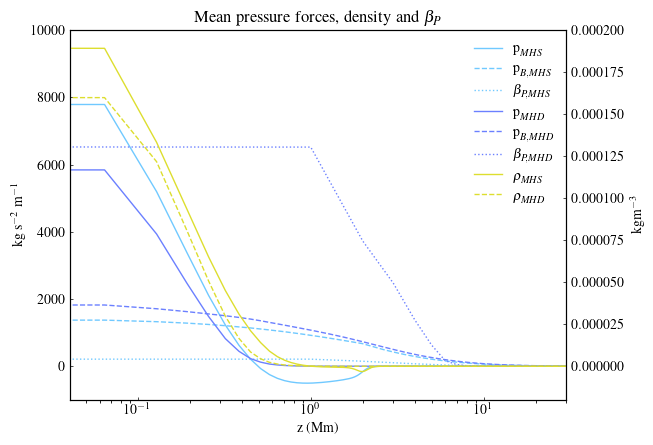

In [44]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(z_arr, fpresmean, linewidth=1.0, c=c1, label=r"$\textrm{p}_{MHS}$")
ax1.plot(
    z_arr,
    magpresmean,
    linewidth=1.0,
    c=c1,
    linestyle="dashed",
    label=r"$\textrm{p}_{B, MHS}$",
)
ax1.plot(plasmabetamean, linewidth=1.0, c=c1, linestyle="dotted", label=r"$\beta_{P, MHS}$")
ax1.plot(
    z_arr, fpresISSImean * 10**-2, linewidth=1.0, c=c2, label=r"$\textrm{p}_{MHD}$"
)
ax1.plot(
    z_arr,
    magpresISSImean,
    linewidth=1.0,
    c=c2,
    linestyle="dashed",
    label=r"$\textrm{p}_{B, MHD}$",
)
ax1.plot(plasmabetaISSImean, linewidth=1.0, c=c2, linestyle="dotted", label=r"$\beta_{P, MHD}$")

ax2.plot(data3d.z, fdenmean, linewidth=1.0, c=c8, label=r"$\rho_{MHS}$")
ax2.plot(
    data3d.z,
    fdenISSImean * 10**6,
    linewidth=1.0,
    c=c8,
    linestyle="dashed",
    label=r"$\rho_{MHD}$",
)


plt.xscale("log")
ax1.set_ylabel(r"kg $\textrm{s}^{-2}$ m$^{-1}$")
ax2.set_ylabel(r"kgm$^{-3}$")

ax1.set_xlabel("z (Mm)")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

lines = lines1 + lines2
labels = labels1 + labels2
plt.legend(lines, labels, frameon=False)

ax1.set_xlim(0, 30)
ax1.set_ylim([-1000, 10000])
ax2.set_ylim([-0.00002000, 0.00020000])
ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)

plt.title(r"Mean pressure forces, density and $\beta_P$")
plotname = folder + "/plasmaparam.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [21]:
iy_norm, ix_norm, iz_norm = np.unravel_index(
    np.argmax(fpresISSI, axis=None),
    fpresISSI.shape,
)

pnorm = fpres[iy_norm, ix_norm, 0]
pISSInorm = fpresISSI[iy_norm, ix_norm, 0]

In [22]:
iy_norm, ix_norm, iz_norm = np.unravel_index(
    np.argmax(fdenISSI, axis=None),
    fdenISSI.shape,
)

rnorm = fden[iy_norm, ix_norm, 0]
rISSInorm = fdenISSI[iy_norm, ix_norm, 0]

In [23]:
fpresmeanNORM = np.zeros_like(z_arr)
fpresISSImeanNORM = np.zeros_like(z_arr)

fdenmeanNORM = np.zeros_like(z_arr)
fdenISSImeanNORM = np.zeros_like(z_arr)


fpresISSImaxNORM = np.zeros_like(z_arr)
fpresmaxNORM = np.zeros_like(z_arr)

fdenISSImaxNORM = np.zeros_like(z_arr)
fdenmaxNORM = np.zeros_like(z_arr)


fpresISSIminNORM = np.zeros_like(z_arr)
fpresminNORM = np.zeros_like(z_arr)

fdenISSIminNORM = np.zeros_like(z_arr)
fdenminNORM = np.zeros_like(z_arr)

for iz in range(nresol_z):

    fpresISSImeanNORM[iz] = fpresISSI[:, :, iz].mean() / pISSInorm
    fpresmeanNORM[iz] = fpres[:, :, iz].mean() / pnorm

    fdenISSImeanNORM[iz] = fdenISSI[:, :, iz].mean() / rISSInorm
    fdenmeanNORM[iz] = fden[:, :, iz].mean() / rnorm

    fpresISSImaxNORM[iz] = fpresISSI[:, :, iz].max() / pISSInorm
    fpresmaxNORM[iz] = fpres[:, :, iz].max() / pnorm

    fdenISSImaxNORM[iz] = fdenISSI[:, :, iz].max() / rISSInorm
    fdenmaxNORM[iz] = fden[:, :, iz].max() / rnorm

    fpresISSIminNORM[iz] = fpresISSI[:, :, iz].min() / pISSInorm
    fpresminNORM[iz] = fpres[:, :, iz].min() / pnorm

    fdenISSIminNORM[iz] = fdenISSI[:, :, iz].min() / rISSInorm
    fdenminNORM[iz] = fden[:, :, iz].min() / rnorm

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7309/1038500545.py:30: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 30)


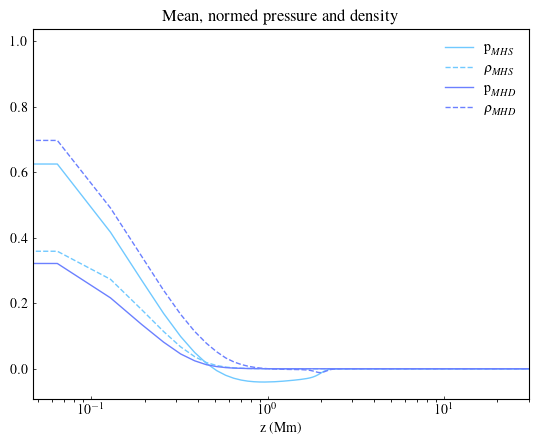

In [ ]:
plt.plot(z_arr, fpresmeanNORM, linewidth=1.0, c=c1, label=r"$\textrm{p}_{MHS}$")
plt.plot(data3d.z, fdenISSImeanNORM, linewidth=1.0, c=c1, linestyle="dashed", label=r"$\rho_{MHS}$")
plt.plot(
    z_arr,
    fpresISSImeanNORM,
    linewidth=1.0,
    c=c2,
    label=r"$\textrm{p}_{MHD}$",
)
plt.plot(
    data3d.z,
    fdenmeanNORM,
    linewidth=1.0,
    c=c2,
    linestyle="dashed",
    label=r"$\rho_{MHD}$",
)





plt.tick_params(direction="in", length=2, width=0.5)
plt.title(r"Mean, normed pressure and density")
plotname = folder + "/plasmaparam_normed.png"

plt.xscale("log")
plt.xlabel("z (Mm)")
plt.legend(frameon=False)
plt.xlim(0, 30)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [22]:
fpresISSINORM = fpresISSI / pISSInorm
fdenISSINORM = fdenISSI / rISSInorm
fpresNORM = fpres / pnorm
fdenNORM = fden / rnorm


pearson_corr_coeff_issi_2(
    fpresISSINORM[60:240, 280:490, 0:469],
    fdenISSINORM[60:240, 280:490, 0:469],
    data3d,
    fpresNORM[60:240, 280:490, 0:469],
    fdenNORM[60:240, 280:490, 0:469],
    heights,
    temps,
)

Pearson Correlation reference value for pressure  PearsonRResult(statistic=0.999999999998969, pvalue=0.0)
Pearson Correlation reference value for density  PearsonRResult(statistic=1.0, pvalue=0.0)
Pearson Correlation actual value for pressure  PearsonRResult(statistic=0.2608592353901983, pvalue=0.0)
Pearson Correlation actual value for density  PearsonRResult(statistic=0.8175222165610205, pvalue=0.0)


: 

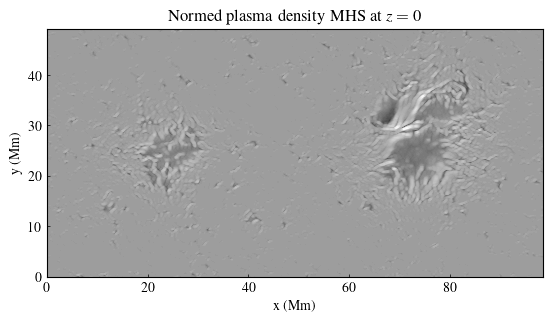

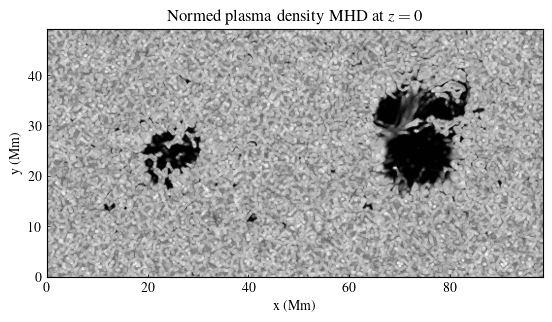

In [177]:
fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_grid,
    y_grid,
    fdenNORM[:, :, 0],
    100,
    cmap=cmap,
    # vmin = data3d.dpressure[:, :, iiz].min(),
    # vmax = data3d.dpressure[:, :, iiz].max(),
)
ax.set_xlabel("x (Mm)")
ax.set_ylabel("y (Mm)")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plt.title(r"Normed plasma density MHS at $z=0$")
plotname = folder + "/dsurf_MHS_0.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
ax.set_box_aspect(data2d.ny / data2d.nx)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_grid,
    y_grid,
    fdenISSINORM[:, :, 0],
    100,
    cmap=cmap,
    # vmin = data3d.dpressure[:, :, iiz].min(),
    # vmax = data3d.dpressure[:, :, iiz].max(),
)
ax.set_xlabel("x (Mm)")
ax.set_ylabel("y (Mm)")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plt.title(r"Normed plasma density MHD at $z=0$")
plotname = folder + "/dsurf_MHD_0.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
ax.set_box_aspect(data2d.ny / data2d.nx)
plt.show()